In [2]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# --- 1. PREPARAÇÃO DOS DADOS ---

# Caminhos originais
orig_cat = "/Users/anacarolinamachado/iA/Lista 12/archive/PetImages/Cat"
orig_dog = "/Users/anacarolinamachado/iA/Lista 12/archive/PetImages/Dog"

# Base de destino
base_dir = "/Users/anacarolinamachado/iA/Lista 12/dataset_500"

# Cria estrutura de diretórios
for split in ['train', 'val', 'test']:
    for classe in ['cats', 'dogs']:
        os.makedirs(os.path.join(base_dir, split, classe), exist_ok=True)

# Copiar 500 imagens válidas de cada classe, com 70/15/15
for classe in ['Cat', 'Dog']:
    origem = orig_cat if classe == 'Cat' else orig_dog
    arquivos = sorted(os.listdir(origem))
    
    # Remove arquivos corrompidos/vazios
    arquivos = [f for f in arquivos if os.path.getsize(os.path.join(origem, f)) > 0]
    arquivos = arquivos[:1000]
    random.shuffle(arquivos)

    n = len(arquivos)
    treino, val, teste = arquivos[:int(0.7*n)], arquivos[int(0.7*n):int(0.85*n)], arquivos[int(0.85*n):]

    for f in treino:
        shutil.copy(os.path.join(origem, f), os.path.join(base_dir, 'train', classe.lower() + 's', f))
    for f in val:
        shutil.copy(os.path.join(origem, f), os.path.join(base_dir, 'val', classe.lower() + 's', f))
    for f in teste:
        shutil.copy(os.path.join(origem, f), os.path.join(base_dir, 'test', classe.lower() + 's', f))


In [ ]:
# --- 2. PRÉ-PROCESSAMENTO E AUGMENTATION ---

IMG_SIZE = (150, 150)
BATCH_SIZE = 8  

# Geradores
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
val_test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    base_dir + '/train',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
val_gen = val_test_datagen.flow_from_directory(
    base_dir + '/val',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary'
)
test_gen = val_test_datagen.flow_from_directory(
    base_dir + '/test',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 1955 images belonging to 2 classes.
Found 852 images belonging to 2 classes.
Found 871 images belonging to 2 classes.


In [7]:
# --- 3. MODELO CNN ---

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treinamento
history = model.fit(
    train_gen,
    epochs=15,
    validation_data=val_gen
)


/Users/anacarolinamachado/iA/meu_ambiente_py310/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 24s 96ms/step - accuracy: 0.5066 - loss: 0.7052 - val_accuracy: 0.5352 - val_loss: 0.6797
Epoch 2/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 20s 83ms/step - accuracy: 0.5608 - loss: 0.6849 - val_accuracy: 0.5106 - val_loss: 0.7573
Epoch 3/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.5826 - loss: 0.6728 - val_accuracy: 0.6643 - val_loss: 0.6176
Epoch 4/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.6258 - loss: 0.6506 - val_accuracy: 0.6878 - val_loss: 0.5902
Epoch 5/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6579 - loss: 0.6368 - val_accuracy: 0.6056 - val_loss: 0.6190
Epoch 6/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 84ms/step - accuracy: 0.6601 - loss: 0.6223 - val_accuracy: 0.6596 - val_loss: 0.5996
Epoch 7/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 21s 85ms/step - accuracy: 0.6728 - loss: 0.6078 - val_accuracy: 0.6866 - val_loss: 0.5885
Epoch 8/15
245/245 ━━━━━━━━━━━━━━━━━━━━ 22s 91ms/step - accuracy: 0.6778 - loss: 0.5948 - 

109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step
              precision    recall  f1-score   support

         cat       0.77      0.72      0.75       436
         dog       0.74      0.78      0.76       435

    accuracy                           0.75       871
   macro avg       0.75      0.75      0.75       871
weighted avg       0.75      0.75      0.75       871



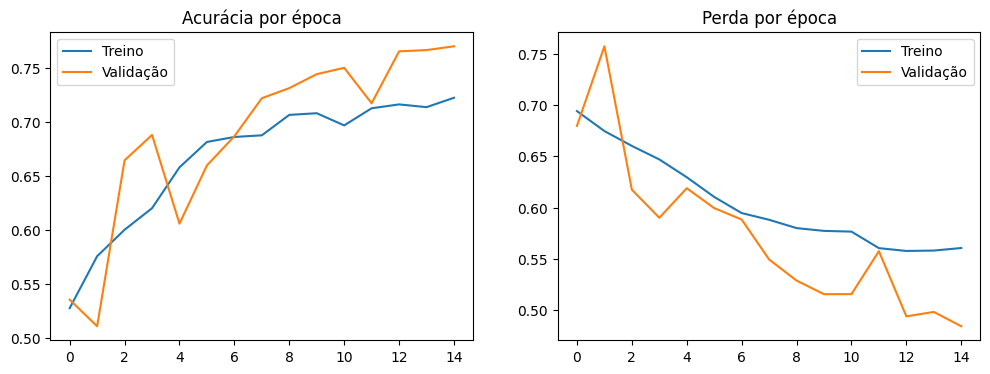

In [8]:
# --- 4. AVALIAÇÃO ---

# Previsão
preds_prob = model.predict(test_gen)
preds = (preds_prob > 0.5).astype(int).flatten()
true_labels = test_gen.classes[:len(preds)]

# Relatório
print(classification_report(true_labels, preds, target_names=['cat', 'dog']))

# Gráficos
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Treino')
plt.plot(history.history['val_accuracy'], label='Validação')
plt.title('Acurácia por época')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Treino')
plt.plot(history.history['val_loss'], label='Validação')
plt.title('Perda por época')
plt.legend()
plt.show()



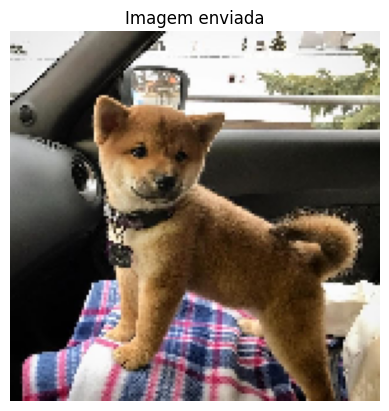

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Classe prevista: Cachorro
Confiança: 72.62%


In [ ]:
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Defina o caminho da imagem nova que você quer testar
path = "/Users/anacarolinamachado/iA/Lista 12/IMG_4336.JPG" 

# Carrega a imagem e mostra na tela
img = image.load_img(path, target_size=(150, 150))
plt.imshow(img)
plt.axis('off')
plt.title('Imagem enviada')
plt.show()

# Pré-processamento: redimensiona e normaliza
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)  

# Realiza a predição
prediction = model.predict(img_array)[0][0]

# Interpreta a saída do modelo
classe = 'Cachorro' if prediction >= 0.5 else 'Gato'
confianca = prediction if prediction >= 0.5 else 1 - prediction

# Exibe resultado
print(f'Classe prevista: {classe}')
print(f'Confiança: {confianca * 100:.2f}%')
